### import libraries

In [1]:
using QuantumOptics, PyPlot, PyCall, JLD

### define parameters for the position and momentum basis

In [2]:
#coupling factor
g=-29.45

#position and momentum basis in x
x_min= -20
x_max = 20
x_steps = 62
dx = (x_max - x_min) / x_steps
b_x = PositionBasis(x_min, x_max, x_steps)
b_px = MomentumBasis(b_x)
xsample = samplepoints(b_x)

#position and momentum basis in y
y_min= -10
y_max = 10
y_steps = 32
dy = (y_max - y_min) / y_steps
b_y = PositionBasis(y_min, y_max, y_steps)
b_py = MomentumBasis(b_y)
ysample = samplepoints(b_y)

#momentum:
px = momentum(b_px)
py = momentum(b_py)

#TransformationOperator for composite bases:
b_comp_x = tensor(b_x, b_y)
b_comp_p = tensor(b_px, b_py)
Txp = transform(b_comp_x, b_comp_p)
Tpx = transform(b_comp_p, b_comp_x)

#Hamiltonians:
Hkinx = LazyTensor(b_comp_p, [1, 2], [px^2/2, one(b_py)])
Hkiny = LazyTensor(b_comp_p, [1, 2], [one(b_px), py^2/2])

Hkinx_FFT = LazyProduct(Txp, Hkinx, Tpx)
Hkiny_FFT = LazyProduct(Txp, Hkiny, Tpx)

Hpsi = diagonaloperator(b_comp_x, Ket(b_comp_x).data) # proportional zu |psi|^2
H0 = LazySum(Hkinx_FFT, Hkiny_FFT, Hpsi)

LazySum(dim=1984x1984)
  basis: [Position(xmin=-20.0, xmax=20.0, N=62) ⊗ Position(xmin=-10.0, xmax=10.0, N=32)]
  operators: 3

### parameters for two gaussian wavepacket

In [8]:
#position
x0 = 5
y0 = 0

#momentum
p0_x = 0
p0_y = 0

#size
sigmax = 2
sigmay= 2

#first wavepacket
psix1 = gaussianstate(b_x, -x0, p0_x, sigmax)
psiy1 = gaussianstate(b_y, y0, p0_y, sigmay)
psi1 = psix1 ⊗ psiy1

#second wavepacket
psix2 = gaussianstate(b_x, x0, -p0_x, sigmax)
psiy2 = gaussianstate(b_y, y0, p0_y, sigmay)
psi2 = psix2 ⊗ psiy2

psi = normalize(psi1 + psi2)

Ket(dim=1984)
  basis: [Position(xmin=-20.0, xmax=20.0, N=62) ⊗ Position(xmin=-10.0, xmax=10.0, N=32)]
           0.0 - 0.0im
           0.0 - 0.0im
       3.0e-17 - 0.0im
       2.6e-16 - 0.0im
       2.0e-15 - 0.0im
     1.405e-14 - 0.0im
     8.909e-14 - 0.0im
     5.091e-13 - 0.0im
   2.62168e-12 - 0.0im
  1.216637e-11 - 0.0im
  5.088034e-11 - 0.0im
  1.917552e-10 - 0.0im
 6.5125695e-10 - 0.0im
               ⋮
  2.9589097e-9 + 0.0im
  8.712173e-10 + 0.0im
 2.3116886e-10 + 0.0im
  5.527646e-11 + 0.0im
   1.19113e-11 + 0.0im
   2.31306e-12 + 0.0im
    4.0478e-13 + 0.0im
     6.384e-14 + 0.0im
      9.07e-15 + 0.0im
      1.16e-15 + 0.0im
       1.3e-16 + 0.0im
       1.0e-17 + 0.0im

In [3]:
function H(t, psi) # updating state-dependent term in Hamiltonian H
	Hpsi.data.nzval .= g*abs2.(psi.data)
	return H0
end

H (generic function with 1 method)

## calculating evolution of the wavepackets - this is where the magic happens!

In [9]:
T = [0:1:100;]
tout, psit = timeevolution.schroedinger_dynamic(T, psi, H)
density = [reshape(abs2.(psi.data), (x_steps, y_steps))' for psi=psit]

101-element Array{LinearAlgebra.Adjoint{Float64,Array{Float64,2}},1}:
 [8.280264835637548e-38 9.424909881696268e-36 … 8.712169533400078e-34 9.424909881697474e-36; 1.709239469456311e-36 1.9455208602181993e-34 … 1.7983946560491405e-32 1.9455208602184486e-34; … ; 2.9022743083259015e-35 3.3034781315455184e-33 … 3.0536590686981138e-31 3.3034781315459405e-33; 1.709239469456311e-36 1.9455208602181993e-34 … 1.7983946560491405e-32 1.9455208602184486e-34]
 [1.1338498389549774e-17 1.14219226694038e-17 … 1.1676338415723232e-17 1.142194521044183e-17; 1.1449630183302387e-17 1.153386812975524e-17 … 1.1790778121858324e-17 1.1533891942473022e-17; … ; 1.1789768876695751e-17 1.187650694677122e-17 … 1.2141017747069214e-17 1.1876528551089516e-17; 1.1449631837081e-17 1.1533870806084012e-17 … 1.1790777692241648e-17 1.1533892619756524e-17]
 [7.21552725342455e-15 7.259345707739178e-15 … 7.392432993552018e-15 7.25934061917462e-15; 7.265869006363887e-15 7.310011149964169e-15 … 7.444037277388971e-15 7.31000598047

### plotting the results

In [39]:
#function for the subplots - because pyplot in julia takes no loops
function make_plot(idx, textx_position, texty_position)
    c = contourf(xsample, ysample, density[idx], clev )
    text(textx_position, texty_position, L"time $t$:"*"$(T[idx])", color="white") #Zeitstempel
    text(textx_position, texty_position+2, L"norm $=$ "*"$(round(norm(psit[idx]),digits = 7))", color = "white") # Normstempel
    xlabel(L"$x / \bar{x}$")
    ylabel(L"$y / \bar{x}$")
end

make_plot (generic function with 2 methods)

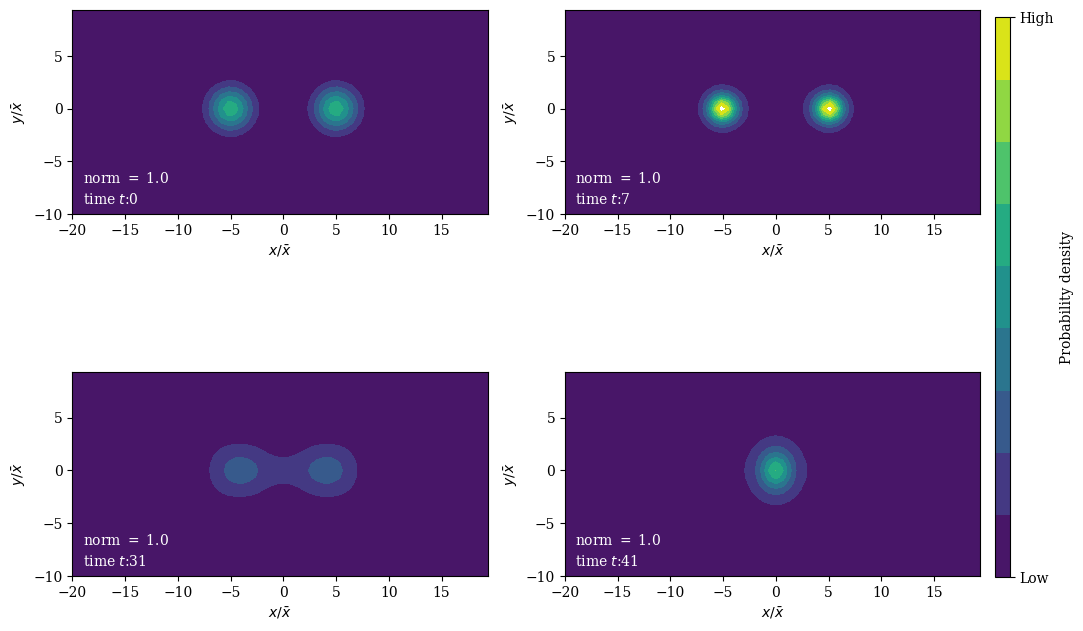

In [38]:
#Daten für Plot:
maxval = maximum(density[10])
textx_position = minimum(xsample)+1
texty_position = minimum(ysample)+1
rc("font", family="serif") #Schrift für Plot
clev = LinRange(0,maxval, 10)
fig = figure(figsize=(10,8)) 

i=1
subplot(221,aspect="equal")
make_plot(i, textx_position, texty_position)

i=8
subplot(222,aspect="equal")
make_plot(i, textx_position, texty_position)

i=32
subplot(223,aspect="equal")
make_plot(i, textx_position, texty_position)

i=42
subplot(224,aspect="equal")
make_plot(i, textx_position, texty_position)

#Colorbar:
cbar_ax = fig.add_axes([1, 0.145, 0.015, 0.7])
cbar = fig.colorbar(c1, cax=cbar_ax, ticks=[0, maxval])
cbar.set_label("Probability density")
cbar.set_ticklabels(["Low", "High"])

tight_layout()
show()